In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

In [2]:
import umap
import umap.plot

In [3]:
## Clustering evaluation
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [4]:
edit_data_path = 'Embeddings/Graph/nSNE/'

# Load Dataframes

## Features

In [5]:
init_k = 128
init_beta = 0.5

In [6]:
s_emb = pd.read_csv(edit_data_path + 'Source_K' + str(init_k) + '_beta' + str(init_beta) + '.txt', header=None)

s_features = s_emb.sort_index().values
print(s_features)
print(s_features.shape)

[[-0.0753517   0.03160037 -0.01630632 ... -0.00523493 -0.00993999
  -0.01828692]
 [-0.08640196  0.0760519  -0.01951726 ... -0.02953458 -0.00689961
  -0.00590422]
 [-0.0610875   0.04219209 -0.02007643 ... -0.0078461  -0.00585597
  -0.01498966]
 ...
 [-0.00037569  0.04096667  0.00947143 ... -0.00265461  0.03973189
  -0.03530876]
 [ 0.04334189  0.0427948  -0.01473937 ... -0.00879302  0.02392511
  -0.00182849]
 [ 0.06380406  0.0369466  -0.01122583 ...  0.02589243  0.01851878
  -0.03561728]]
(15685, 128)


In [7]:
t_emb = pd.read_csv(edit_data_path + 'Target_K' + str(init_k) + '_beta' + str(init_beta) + '.txt', header=None)

t_features = t_emb.sort_index().values
print(t_features)
print(t_features.shape)

[[ 7.35538602e-02 -1.35619659e-02 -1.23645051e-03 ... -1.38742942e-02
   6.85299858e-02 -3.07987388e-02]
 [ 7.97829628e-02 -3.96389998e-02 -2.02281121e-03 ... -5.56957535e-03
   6.01063929e-02 -8.47082119e-03]
 [ 8.24837163e-02 -1.82146206e-02  5.45679126e-03 ... -1.37532623e-02
   6.39942214e-02 -2.97223441e-02]
 ...
 [-9.79988836e-05 -5.27284928e-02  2.05241330e-03 ... -4.76261880e-03
  -2.34230254e-02 -4.09662686e-02]
 [-3.22061256e-02 -4.18173745e-02 -2.65532900e-02 ...  1.32501302e-02
  -3.36789875e-03 -3.15828770e-02]
 [-6.28939867e-02 -1.50194718e-02 -7.70067982e-03 ...  2.11271364e-02
   6.67328341e-03 -1.81333199e-02]]
(15685, 128)


## Edges

In [8]:
# all edges
# tt_df = pd.read_csv('./hvppi_preds/hvppi_edgelist_idx.csv') 
# tt_df

In [9]:
### train_test ### 
tt_df = pd.read_csv('./umap_tt_df.csv') 

## Label
tt_df.loc[tt_df['Class'] == '0.99', 'Label'] = 2
tt_df.loc[tt_df['Class'] == '0.95', 'Label'] = 1
tt_df.loc[tt_df['Class'] == 'neg', 'Label'] = 0

tt_df['Label'] = tt_df['Label'].astype(int)

tt_df

,Protein1_ID,Protein2_ID,Class,Label
0,9561,7,0.99,2
1,11092,7,0.99,2
2,10381,7,0.99,2
3,1068,7,0.99,2
4,13956,7,0.99,2
...,...,...,...,...
8773,14890,30,neg,0
8774,15118,30,neg,0
8775,3257,30,neg,0
8776,15625,30,neg,0


In [10]:
# ## Experimentally Verified
# tt_df = pd.read_csv('./edges/expt_verified_umap_eval.csv')
# tt_df

In [11]:
tt_df['Class'].value_counts()

neg     4378
0.95    2942
0.99    1458
Name: Class, dtype: int64

In [12]:
## Get edge embeddings from node embeddings
def generate_edge_emb_hadamard(input_df, source_feat, target_feat):
    
    edges_count = input_df.shape[0]

    X = np.empty((edges_count, source_feat.shape[1])) ## All embeddings
    k = 0

    for i in range(len(input_df)):
        u = source_feat[input_df['Protein1_ID'][i]] ## Source
        v = target_feat[input_df['Protein2_ID'][i]] ## Target

        hadamard = np.multiply(u, v)

        X[k] = hadamard
        k = k + 1

    print(X)
    print(X.shape)
    
    ## Target
    target = input_df['Class'].values
    y_true = input_df['Label'].values
    
#     target = input_df['Class_3'].values
#     y_true = input_df['Label_3'].values
    
    return X, target, y_true

In [13]:
edge_emb_arr, class_labels, labels_true = generate_edge_emb_hadamard(tt_df, s_features, t_features)

[[ 5.67915645e-03  3.95566661e-04 -4.54221944e-06 ...  3.80802044e-04
   1.31988783e-03  9.29589033e-05]
 [ 3.84996699e-03 -6.41408063e-04 -4.74974926e-06 ...  1.86531463e-04
   1.02980049e-03  3.58873673e-04]
 [ 4.89678984e-03  4.16910209e-03  1.22989078e-05 ...  6.25223759e-05
   3.22686202e-04  7.46849656e-04]
 ...
 [ 2.03150194e-03  4.48617946e-04  1.84187122e-05 ... -5.67359611e-04
   2.02427758e-03  1.32830227e-03]
 [ 1.05018849e-03 -1.21567013e-04  1.44158473e-05 ... -6.45688547e-04
   1.62944768e-03  1.56569796e-03]
 [ 1.48958963e-03  7.34250247e-04 -3.19833546e-05 ... -8.92386287e-04
   2.97010054e-03  1.15847153e-03]]
(8778, 128)


# Plot UMAP

In [14]:
mapper = umap.UMAP().fit(edge_emb_arr)

<AxesSubplot:>

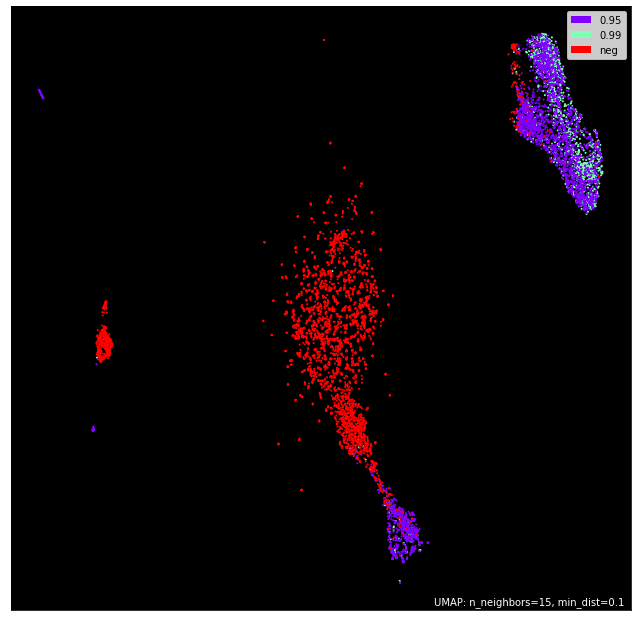

In [15]:
# umap.plot.points(mapper, labels=class_labels)
umap.plot.points(mapper, labels=class_labels, theme='fire')

### Other evaluation metrics

In [16]:
# def get_metrics(get_edge_emb, true_labels, pred_labels):
    
#     h = metrics.homogeneity_score(true_labels, pred_labels)
#     c = metrics.completeness_score(true_labels, pred_labels)
#     v = metrics.v_measure_score(true_labels, pred_labels)
    
#     fm = metrics.fowlkes_mallows_score(true_labels, pred_labels)
    
#     s = metrics.silhouette_score(get_edge_emb, pred_labels, metric='euclidean')
#     db = davies_bouldin_score(get_edge_emb, pred_labels)
    
#     ch = metrics.calinski_harabasz_score(get_edge_emb, pred_labels)
    
#     return([h, c, v, fm, s, db, ch])

In [17]:
def get_metrics(get_edge_emb, true_labels, pred_labels):
    
    h = metrics.homogeneity_score(true_labels, pred_labels)
    c = metrics.completeness_score(true_labels, pred_labels)
    v = metrics.v_measure_score(true_labels, pred_labels)
    
    fm = metrics.fowlkes_mallows_score(true_labels, pred_labels)
    
    ## adjusted_rand_score
    a_rand = metrics.adjusted_rand_score(true_labels, pred_labels) 
    a_mut_info = metrics.adjusted_mutual_info_score(true_labels, pred_labels)
    
    s = metrics.silhouette_score(get_edge_emb, pred_labels, metric='euclidean')
#     db = davies_bouldin_score(get_edge_emb, pred_labels)
#     ch = metrics.calinski_harabasz_score(get_edge_emb, pred_labels)
    
    return([h, c, v, fm, a_rand, a_mut_info, s])

In [18]:
## K-means clustering
# kmeans_model = KMeans(n_clusters=4, random_state=1).fit(edge_emb_arr)
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(edge_emb_arr)
labels = kmeans_model.labels_

## Clustering evaluation
metrics_arr = get_metrics(edge_emb_arr, labels_true, labels)

## Round all elements in metrics_arr to 4 d.p.
metrics_arr_r = np.round(metrics_arr, 4)
print(metrics_arr_r)

[0.5419 0.613  0.5753 0.7516 0.5745 0.5752 0.3668]


## UMAP VS K-Means

In [19]:
'''
    https://umap-learn.readthedocs.io/en/latest/clustering.html
'''

'\n    https://umap-learn.readthedocs.io/en/latest/clustering.html\n'

In [20]:
import matplotlib.pyplot as plt

In [21]:
edge_emb_arr, class_labels, labels_true = generate_edge_emb_hadamard(tt_df, s_features, t_features)

[[ 5.67915645e-03  3.95566661e-04 -4.54221944e-06 ...  3.80802044e-04
   1.31988783e-03  9.29589033e-05]
 [ 3.84996699e-03 -6.41408063e-04 -4.74974926e-06 ...  1.86531463e-04
   1.02980049e-03  3.58873673e-04]
 [ 4.89678984e-03  4.16910209e-03  1.22989078e-05 ...  6.25223759e-05
   3.22686202e-04  7.46849656e-04]
 ...
 [ 2.03150194e-03  4.48617946e-04  1.84187122e-05 ... -5.67359611e-04
   2.02427758e-03  1.32830227e-03]
 [ 1.05018849e-03 -1.21567013e-04  1.44158473e-05 ... -6.45688547e-04
   1.62944768e-03  1.56569796e-03]
 [ 1.48958963e-03  7.34250247e-04 -3.19833546e-05 ... -8.92386287e-04
   2.97010054e-03  1.15847153e-03]]
(8778, 128)


In [22]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(edge_emb_arr)
standard_embedding

array([[18.499596 , 10.399623 ],
       [17.900063 , 10.1387205],
       [19.71108  , 11.271685 ],
       ...,
       [ 3.9970994,  5.4254413],
       [ 6.653745 , 10.983434 ],
       [ 5.2622795,  5.147647 ]], dtype=float32)

In [23]:
# neg     223194
# 0.90     30228
# 0.95     15782
# 0.99      2872

# [0 1 2 3] [neg 0.95 0.99 0.90] [223194  15782   2872  30228]

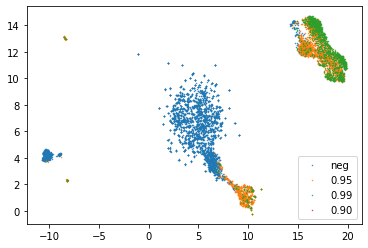

In [24]:
## Actual labels
## Filter rows of original data (standard_embedding)
label_0 = standard_embedding[labels_true == 0]
label_1 = standard_embedding[labels_true == 1]
label_2 = standard_embedding[labels_true == 2]
label_3 = standard_embedding[labels_true == 3]

arr_0 = plt.scatter(label_0[:,0] , label_0[:,1], s=0.2, cmap='Spectral') ## plt.scatter(edge 1, edge 2) 
arr_1 = plt.scatter(label_1[:,0] , label_1[:,1], s=0.2, cmap='Spectral') 
arr_2 = plt.scatter(label_2[:,0] , label_2[:,1], s=0.2, cmap='Spectral')
arr_3 = plt.scatter(label_3[:,0] , label_3[:,1], s=0.2, cmap='Spectral')

plt.legend([arr_0, arr_1, arr_2, arr_3], ['neg', '0.95', '0.99','0.90'])
plt.show()

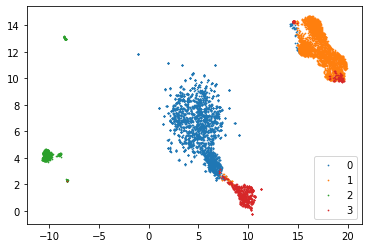

In [25]:
## K-means
kmeans_labels = KMeans(n_clusters=4).fit_predict(edge_emb_arr)

## Filter rows of original data (standard_embedding)
label_0 = standard_embedding[kmeans_labels == 0]
label_1 = standard_embedding[kmeans_labels == 1]
label_2 = standard_embedding[kmeans_labels == 2]
label_3 = standard_embedding[kmeans_labels == 3]

arr_0 = plt.scatter(label_0[:,0] , label_0[:,1], s=0.5, cmap='Spectral') ## plt.scatter(edge 1, edge 2) 
arr_1 = plt.scatter(label_1[:,0] , label_1[:,1], s=0.5, cmap='Spectral') 
arr_2 = plt.scatter(label_2[:,0] , label_2[:,1], s=0.5, cmap='Spectral')
arr_3 = plt.scatter(label_3[:,0] , label_3[:,1], s=0.5, cmap='Spectral')

plt.legend([arr_0, arr_1, arr_2, arr_3], ['0', '1', '2','3'])
plt.show()

In [26]:
print(labels_true)

unique, counts = np.unique(labels_true, return_counts=True)
print(unique, counts)

[2 2 2 ... 0 0 0]
[0 1 2] [4378 2942 1458]


In [27]:
print(kmeans_labels)

unique, counts = np.unique(kmeans_labels, return_counts=True)
print(unique, counts)

[1 1 1 ... 0 0 0]
[0 1 2 3] [3747 3540  608  883]


In [28]:
## metrics
metrics_arr = get_metrics(edge_emb_arr, labels_true, kmeans_labels)
metrics_arr

[0.5579363933765888,
 0.4926461970855156,
 0.5232625115017064,
 0.7205104361624362,
 0.5529681085057725,
 0.5231112609412436,
 0.3085285079914557]

In [29]:
np.round(metrics_arr, 4)

array([0.5579, 0.4926, 0.5233, 0.7205, 0.553 , 0.5231, 0.3085])

## Create edgelist

In [30]:
tt_df_1 = tt_df[['Protein1_ID', 'Protein2_ID', 'Label_s']]
tt_df_2 = tt_df[['Protein2_ID', 'Protein1_ID', 'Label_s']]
edges = pd.concat([tt_df_1, tt_df_2], ignore_index=True)
edges

KeyError: "['Label_s'] not in index"

In [ ]:
# edges.to_csv('./edges/SNE/iav.edges.txt', index=False, header=None, sep=' ')

In [ ]:
tt_df['Label_s'] = tt_df['Label_3']
tt_df.loc[tt_df['Label_3'] == 0, 'Label_s'] = -1

In [ ]:
tt_df['Label_s'].value_counts()

In [ ]:
df = shuffle(tt_df)
df

In [ ]:
c0_org = df[df['Label'] == 0]
c0_org

In [ ]:
df['Class'].value_counts()

In [ ]:
df['Label'].value_counts()

In [ ]:
c0 = df[df['Label'] == 0].reset_index(drop=True) ## neg
c1 = df[df['Label'] == 1].reset_index(drop=True) ## 0.95
c2 = df[df['Label'] == 2].reset_index(drop=True) ## 0.99
c3 = df[df['Label'] == 3].reset_index(drop=True) ## 0.90

In [ ]:
## Take 25% from each class to form testset
c0_test= c0.sample(frac = 0.25, replace = False) ## 25% of positive dataset
c0_train = c0[~c0.index.isin(c0_test.index)]
print(len(c0_test), len(c0_train))

In [ ]:
c1_test= c1.sample(frac = 0.25, replace = False) ## 25% of positive dataset
c1_train = c1[~c1.index.isin(c1_test.index)]
print(len(c1_test), len(c1_train))

In [ ]:
c2_test= c2.sample(frac = 0.25, replace = False) ## 25% of positive dataset
c2_train = c2[~c2.index.isin(c2_test.index)]
print(len(c2_test), len(c2_train))

In [ ]:
c3_test= c3.sample(frac = 0.25, replace = False) ## 25% of positive dataset
c3_train = c3[~c3.index.isin(c3_test.index)]
print(len(c3_test), len(c3_train))

In [ ]:
## Concatenate
testset = pd.concat([c2_test, c1_test, c3_test, c0_test], ignore_index=True)
testset

In [ ]:
testset['Label_3'].value_counts()

In [ ]:
testset['Label_s'] = testset['Label_3']
testset.loc[testset['Label_3'] == 0, 'Label_s'] = -1
testset

In [ ]:
trainset = pd.concat([c2_train, c1_train, c3_train, c0_train], ignore_index=True)
trainset

In [ ]:
trainset['Label_s'] = trainset['Label_3']
trainset.loc[trainset['Label_3'] == 0, 'Label_s'] = -1
trainset

In [ ]:
testset_f = testset[['Protein1_ID', 'Protein2_ID', 'Label_s']]
trainset_f = trainset[['Protein1_ID', 'Protein2_ID', 'Label_s']]

In [ ]:
## Undirected edgelist
testset_f2 = testset[['Protein2_ID', 'Protein1_ID', 'Label_s']]
trainset_f2 = trainset[['Protein2_ID', 'Protein1_ID', 'Label_s']]

In [ ]:
testset_f2.columns = ['Protein1_ID', 'Protein2_ID', 'Label_s']
trainset_f2.columns = ['Protein1_ID', 'Protein2_ID', 'Label_s']

In [ ]:
testset_final = pd.concat([testset_f, testset_f2], ignore_index=True)

In [ ]:
trainset_final = pd.concat([trainset_f, trainset_f2], ignore_index=True)
trainset_final

In [ ]:
# testset_final.to_csv('./edges/SNE/iav.test_0.txt', index=False, header=None, sep=' ')
# trainset_final.to_csv('./edges/SNE/iav.train_0.txt', index=False, header=None, sep=' ')

In [ ]:
# ## Train : Val = 9 : 1
# pos_val = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
# pos_train = pos[~pos.index.isin(pos_val.index)]

# neg_val = neg.sample(frac = 0.1, replace = False) ## 10% of negative dataset
# neg_train = neg[~neg.index.isin(neg_val.index)]